In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Dataframe columns
The following dataframe has columns which do have the following meaning:
 
0. Frequency (in THz). This is the **independent variable** which is influencing the overall procedure. 

1. Wavelength (in nm, can be directly derived from frequency of course).

2. Intensity (defined as the **metric of interest**, intensity is very significant for this analysis). Please consider that the square root of the intensity can be analysed as the Electric Field. 

3. Phase (between minus and plus infinity).

4. **Phase cutted** (with respect to those frequencies corresponding to values of intensity equal to zero).

In [4]:
file_name = "LLNL_160809_freq.csv"
df = pd.read_csv("data/"+file_name, header = None)
df.columns = ["Frequency", "Wavelength", "Intensity", "Phase", "Phase (cutted)"] 
df.describe()

,Frequency,Wavelength,Intensity,Phase,Phase (cutted)
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,388.703722,797.636767,0.077578,-335.902940,0.007874
std,69.084920,147.503173,0.218707,541.012492,0.212221
min,269.220000,590.333000,0.000000,-2491.000000,-1.196000
25%,328.961500,668.977500,0.000000,-312.586500,0.000000
50%,388.704000,771.796000,0.000000,-179.213000,0.000000
75%,448.445500,911.960000,0.000000,-7.072500,0.000000
max,508.188000,1114.331000,1.000000,350.355000,1.373000


Considering now the purposes of this analysis, it is clear that in this case it is possible to discard some columns from consideration. Such columns are *phase* (since the cutted version is preferred) and *wavelength* (which can also be obtained, if needed considering the very index of the dataframe).

In [18]:
try: 
    df.drop(columns = ["Wavelength", "Phase"], inplace = True)
except KeyError: 
    pass

# selecting only the interesting elements for the analysis
frequency = df.loc[:, "Frequency"].values * 10**12 #THz to Hz
intensity = df.loc[:, "Intensity"].values
electric_field = np.sqrt(intensity)

The upcoming `fft` algorithm requires the input frequencies to be equidistant (~constant value for np.diff), but the control system does not allow such a strategy, therefore it is important to obtain a way with which to approximate intensity (and electric field) directly from frequency values. 
To do so, rbf-kernellized regression will be used. 

In [19]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from scipy.interpolate import interp1d, UnivariateSpline
import time

# setting a random state
rs = 7

# building a model that infers intensity from frequency
Xtrain, Xtest, ytrain, ytest = train_test_split(frequency.reshape(-1,1), intensity, test_size=0.1, random_state=rs)

# using kernel Ridge given the high non linearity of the function considered
model_intensity = make_pipeline(KernelRidge(alpha = 1, kernel = "rbf"))

start_time = time.time()
model_intensity_interp = interp1d(Xtrain.reshape(-1,), ytrain)
interp_time = time.time() - start_time

start_time = time.time()
model_intensity.fit(Xtrain, ytrain)
train_time = time.time() - start_time

start_time = time.time()
yspline = model_intensity_interp(Xtest)
interp_inference_time = time.time() - start_time

start_time = time.time()
ypred = model_intensity.predict(Xtest)
reg_inference_time = time.time() - start_time

print(f"RBF-Kernel Ridge MSE: {mean_squared_error(ytest, ypred)}")
print("Training time: {:.5e} s".format(train_time))
print("Inference time: {:.5e} s".format(reg_inference_time))

print(f"Spline MSE: {mean_squared_error(ytest, yspline)}")
print("(interpolation) Training time: {:.5e} s".format(interp_time))
print("(interpolation) Inference time: {:.5e} s".format(interp_inference_time))


RBF-Kernel Ridge MSE: 0.0601077572815534
Training time: 5.58808e-02 s
Inference time: 2.10190e-03 s
Spline MSE: 7.707170367077619e-06
(interpolation) Training time: 3.26872e-04 s
(interpolation) Inference time: 2.62976e-04 s


Now that a model able to predict the intensity value for any given frequency it has been obtained it is possible to use it so as to obtain what is necessary in this case: an equidistant in frequency set of intensity in the frequency domain (to use the `fft` algorithm and translate them in the time domain). 

(1000,)


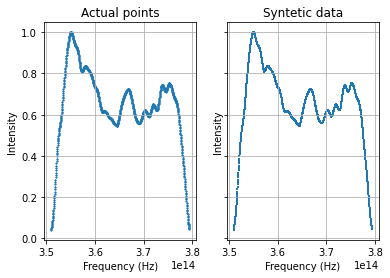

In [53]:
# The interpolation is faster and more accurate therefore regular interpolation is what it will be used
model_intensity = model_intensity_interp

# Cutting the value of frequency outside of the spectrum considered. This is also done considering measurement noise (from which
# the presence of the variable thresh on the actual zero intensity arises).

thresh = 3e-2
start_freq, end_freq = sorted((frequency[np.argwhere(intensity.reshape(-1,) > 0 + thresh).reshape(-1,)[0]], frequency[np.argwhere(intensity.reshape(-1,) > 0 + thresh).reshape(-1,)[-1]]))

# 1k values of frequency
num_points = int(1e3)
frequency_spaced = np.linspace(start_freq, end_freq, num_points, endpoint=True).reshape(-1,)
print(frequency_spaced.shape)
intensity_spaced = model_intensity(frequency_spaced)

fig, ax = plt.subplots(ncols = 2, sharey = True)

ax[0].scatter(frequency, intensity, marker = "*", s = 2)
ax[0].set_title("Actual points")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Intensity")
ax[0].grid()

ax[1].scatter(frequency_spaced, intensity_spaced, marker = "+", s = 2)
ax[1].set_title("Syntetic data")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Intensity")
ax[1].grid()

While the second plot in the upper figure might look as a continous line, it is important to note that it is indeed a scatter plot. The reason why it looks continous is that the number of proposed points is equal to 1'000. 

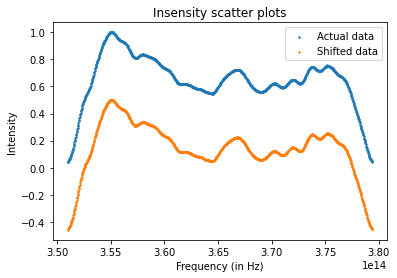

In [54]:
frequency = frequency_spaced; intensity = intensity_spaced
half_max = intensity.max()/2

shifted_intensity = intensity - half_max

fig, ax = plt.subplots()
ax.scatter(frequency, intensity, label = "Actual data", s = 2)
ax.scatter(frequency, shifted_intensity, label = "Shifted data", s = 2)

ax.set_title("Insensity scatter plots")
ax.set_xlabel("Frequency (in Hz)")
ax.set_ylabel("Intensity")

ax.legend()

The orange scatter plot corresponds to the blue one, shifted downwards by half the maximal value reached. This is done so to find the frequencies corresponding to such half max since these frequencies are nothing but the *roots* of the orange curve. 

In [55]:
shifted_model = UnivariateSpline(frequency, shifted_intensity, s=0)
f1, f2 = shifted_model.roots()

Once the frequencies have been obtained it is then possible to obtain the *carrier frequency* (defined as the mean frequency between these roots). Once this is done, it is possible to extract the *angular frequency* which could then be used subsequently in a particular model used to generate the phase.

Since the frequency is expressed in THz to obtain the frequency expressed in IS-uom it is necessary to convert THz into Hz.

In [56]:
# carrier angular frequency - wcarrier
wcarrier = 2 * np.pi * abs(f1 + f2)/2

Once the carrier frequency of the pulse it has been obtained it is possible to define the phase of such a pulse using a particular polynomial expansion which is then defined in different parameters. This polynomial expansion essentially defines the phase as a function of the considered frequency $f$, the carrier frequency $w_0$ and three parameters characteristical of the system, $GDD, TOD$ and $FOD$. This relationship is presented in the following equation: 
$$
\begin{equation}
\varphi = \frac 12 (1000 \cdot GDD - \alpha_{GDD}) \cdot 10^{-30} \cdot (2 \pi f - w_0)^2 + \frac 16 (1000 \cdot TOD - \alpha_{TOD}) \cdot 10^{-45} \cdot (2 \pi f - w_0)^3 + 
\frac 1{24} (1000 * FOD - \alpha_{FOD}) \cdot 10^{-60} \cdot (2 \pi f - w_0)^4
\end{equation}
$$

With the parameters $\alpha_{GDD}, \alpha_{TOD}$ and $\alpha_{FOD}$ being considered to take into account the phase distortion taking place in between of the pulse emitter and pulse collector (which are physically separated and therefore the phase changes in between them). 

In [57]:
GDD = 27
TOD = 40
FOD = 50

phase = (1/2)*(GDD*1000 - 25000)*1e-30*(2*np.pi*frequency - wcarrier)**2 + \
        (1/6)*(TOD*1000-30000)*1e-45*(2*np.pi*frequency - wcarrier)**3 + \
        (1/24)*(FOD*1000 - 50000)*1e-60*(2*np.pi*frequency - wcarrier)**4

In [59]:
def phase_coefficients(f:np.array, phase:np.array, degree:int=4)->np.array:
    """This function maps frequency into the corresponding phase using polynomial fit. It is interesting to note that the polynomial fitting depends on coefficients which
    can be reconduced to the actual controllable ones (GDD, TOD, ...).

    Args:
        f (np.array): An array of frequency values (in Hz).
        phase (np.array): An array in which it is presented the phase wrt the given frequency. 
        degree (int): The degree of the polynomial used to fit the curve. Defaults to 4. 

    Returns:
        np.array: The coefficients of the polynomial fit.
    """
    coeff = np.polyfit(x = f, y = phase, deg = degree)
    return coeff[::-1]

def phase_reconstruction(f:np.array, coeff:np.array)->np.array: 
    """This function reconstructs the corresponding phase starting from frequencies values using input coefficients of a polynomial fit.  
    The degree of the polynomial fit used is equal to the number of coefficients. 

    Args:
        f (np.array): Array of frequencies for which to reconstruct the phase.
        coeff (np.array): Array of coefficients to be used in reconstructing the coefficients. 

    Returns:
        np.array: The phase reconstructed according to the given coefficients.
    """
    n, = coeff.shape
    phase = 0
    # reconstructing the phase from the input
    for i in range(n): 
        phase += coeff[i] * f ** i
    
    return phase

def phase_emitted(frequency:np.array, intensity:np.array, GDD:float, TOD:float, FOD:float)->np.array: 

    phase = (1/2)*(GDD*1000 - 25000)*1e-30*(2*np.pi*frequency - wcarrier)**2 + \
            (1/6)*(TOD*1000-30000)*1e-45*(2*np.pi*frequency - wcarrier)**3 + \
            (1/24)*(FOD*1000 - 50000)*1e-60*(2*np.pi*frequency - wcarrier)**4
    

Once the phase is reconstructed with respect to controllable parameters it is possible to control the reconstruction itself. Since the final objective is to control the parameters to control the temporal impulse shape, it is necessary to express the temporal pulse shape wrt the phase. This can be done using `fft`. 

In [60]:
from scipy.fft import fft, fftfreq, fftshift

def temporal_profile(
    step, 
    spectral_phase:np.array, 
    spectral_intensity:np.array,
    num_points_increment:int=int(2e4), 
    )->np.array:
    """This function returns the temporal profile of the pulse given the intensity itself and the phase. 

    Args:
        step (float): Sample-points step in the frequency domain.
        spectral_phase (np.array): Phase (represented in the frequency domain).
        spectral_intensity (np.array): Intensity (represented in the frequency domain)
        num_points_increment (int, optional): Increment in the number of sample points to consider for the fft algorithm. Defaults to int(2e4).

    Returns:
        np.array: Time-representation of intensity.
    """
    sample_points = len(spectral_intensity) + num_points_increment
    time = fftshift(fftfreq(sample_points, d=abs(step)))

    # padding the spectral intensity and phase to increase sample complexity for the fft algorithm
    spectral_intensity = np.pad(spectral_intensity, (num_points_increment//2, num_points_increment//2), "constant", constant_values = (0,0))
    spectral_phase = np.pad(spectral_phase, (num_points_increment//2, num_points_increment//2), "constant", constant_values = (0,0))
    
    field = fftshift(fft(spectral_intensity * np.exp(1j * spectral_phase)))
    field_squaremodulus = np.real(field * np.conj(field)) # only for casting reasons

    return field_squaremodulus/field_squaremodulus.max()

Once a function to represent a pulse in the time domain it has been provided, it is possible to use it accordingly.

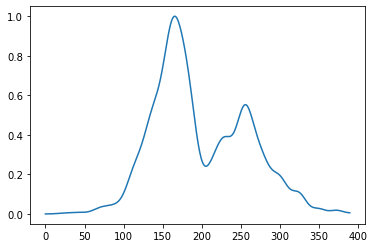

In [63]:
def time_intensity(frequency:np.array, phase:np.array, intensity:np.array)->np.array: 
    """This function returns the temporal representation of a pulse represented in the frequency domain with a certain phase. 

    Args:
        frequency (np.array): Frequencies at which the intensity of the pulse is measured. 
        phase (np.array): Phase (depending on the frequency).
        intensity (np.array): Intensity of the pulse (depending on the frequency).

    Returns:
        np.array: Temporal representation of the pulse considered
    """
    
    # obtain (controlled) phase coefficients
    phase_coeff = phase_coefficients(frequency, phase)
    # reconstruct the phase with respect to these coefficients
    phase_reconstructed = phase_reconstruction(frequency, phase_coeff)
    # obtain sampling step (in the frequency domain)
    step = np.diff(frequency)[0]
    # represent intensity in temporal profile
    temporal_intensity = temporal_profile(step, phase_reconstructed, intensity)

    return temporal_intensity

plt.plot(time_intensity(frequency, phase, intensity)[10300:10690])